In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table,vstack
%matplotlib inline
import json
import pandas as pd
import sncosmo
import sys
sys.path.append('/home/mi/Desktop/project-sn-fitter/project')
import sedfit.utils
import sedfit.mangle
import pickle
from astropy.convolution import Gaussian1DKernel, convolve

In [2]:
example_spectrum = Table.read('example_spectrum',format='ascii')

In [3]:
example_spectrum.colnames

['wavelength', 'flux', 'e_flux']

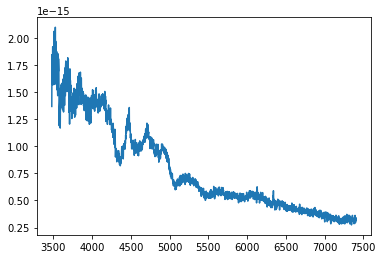

In [4]:
plt.plot(example_spectrum['wavelength'],example_spectrum['flux'])

In [5]:
datafile = 'SN2005hk.json'
data = pd.read_json(datafile)

In [6]:
data = data['SN2005hk']

In [7]:
redshift = float(data['redshift'][0]['value'])
print 'redshift=',redshift

redshift= 0.01306


In [8]:
# photometry = pd.read_json(pd.DataFrame(data['photometry']).to_json(),orient='column')

In [9]:
# print photometry.columns
# photometry.rename(columns={x: x.encode('ascii') for x in photometry.columns})
# photometry = Table.from_pandas(photometry)    
# photometry['Filter'] = photometry['band']
# photometry['Mag'] = photometry['magnitude']
# photometry['MagErr'] = photometry['e_magnitude']
# photometry['MJD'] = photometry['time']
# photometry['Survey'] = photometry['telescope']

In [10]:
# phot = photometry['Filter','Mag','MagErr','MJD','Survey','system','source'][~photometry['Mag'].mask]
# phot['Survey'][phot['source'] == '11,25'] = 'CfA3'
# phot['Survey'][phot['Survey'] == 'PAIRITEL'] = 'CfAIR2'
# phot = phot['Filter','Mag','MagErr','MJD','Survey'][~phot['Survey'].mask]
# phot['Filter'][phot['Survey']=='SDSS'] = [x[0:1] for x in phot['Filter'][phot['Survey']=='SDSS']]
# phot['Filter'][phot['Filter']=='Ks'] = 'K_s'
# a1 = phot['Filter']
# c = ("-" * len(phot))
# a2 = phot['Survey']
# phot['Filter'] = map(''.join, zip(a2, c, a1))
# phot['Filter'][phot['Survey']=='CfA3'] = [x+'K' for x in phot['Filter'][phot['Survey']=='CfA3']]
# phot = phot[~phot['MagErr'].mask]
# phot['Survey'] = [str(x) for x in phot['Survey']]

In [11]:
# cspdata = Table.read('CSP.dat',format='ascii')
# a1 = cspdata['Filter']
# c = ("-" * len(cspdata))
# a2 = cspdata['Survey']
# inst = [x[0:1] for x in cspdata['Instrument']]
# cspdata['Filter'] = map(''.join, zip(a2, c, a1,inst))

In [12]:
# phot = vstack([phot,cspdata],join_type='inner')

In [13]:
photdata = Table.read('phot.dat',format='ascii')
a1 = photdata['Filter']
c = ("-" * len(photdata))
a2 = photdata['Survey']
photdata['Instrument'].fill_value = ''
inst = [x[0:1] for x in photdata['Instrument'].filled()]
photdata['Filter'] = map(''.join, zip(a2, c, a1,inst))

In [14]:
photdata

Name,MJD,Filter,Mag,MagErr,Survey,Name_upper,Name_alt,Type,Instrument
str8,float64,str10,float64,float64,str6,str8,str8,str3,str9
SN2005hk,53675.11,CSP-uS,16.807,0.016,CSP,SN2005HK,SN2005hk,--,Swope
SN2005hk,53682.08,CSP-uS,16.307,0.014,CSP,SN2005HK,SN2005hk,--,Swope
SN2005hk,53683.08,CSP-uS,16.315,0.017,CSP,SN2005HK,SN2005hk,--,Swope
SN2005hk,53684.12,CSP-uS,16.36,0.018,CSP,SN2005HK,SN2005hk,--,Swope
SN2005hk,53687.09,CSP-uS,16.553,0.019,CSP,SN2005HK,SN2005hk,--,Swope
SN2005hk,53689.16,CSP-uS,16.792,0.024,CSP,SN2005HK,SN2005hk,--,Swope
SN2005hk,53690.11,CSP-uS,16.937,0.023,CSP,SN2005HK,SN2005hk,--,Swope
SN2005hk,53694.15,CSP-uS,17.658,0.026,CSP,SN2005HK,SN2005hk,--,Swope
SN2005hk,53695.14,CSP-uS,17.855,0.029,CSP,SN2005HK,SN2005hk,--,Swope


In [15]:
phot = photdata.copy()

In [16]:
phot.show_in_notebook()

idx,Name,MJD,Filter,Mag,MagErr,Survey,Name_upper,Name_alt,Type,Instrument
0,SN2005hk,53675.11,CSP-uS,16.807,0.016,CSP,SN2005HK,SN2005hk,--,Swope
1,SN2005hk,53682.08,CSP-uS,16.307,0.014,CSP,SN2005HK,SN2005hk,--,Swope
2,SN2005hk,53683.08,CSP-uS,16.315,0.017,CSP,SN2005HK,SN2005hk,--,Swope
3,SN2005hk,53684.12,CSP-uS,16.36,0.018,CSP,SN2005HK,SN2005hk,--,Swope
4,SN2005hk,53687.09,CSP-uS,16.553,0.019,CSP,SN2005HK,SN2005hk,--,Swope
5,SN2005hk,53689.16,CSP-uS,16.792,0.024,CSP,SN2005HK,SN2005hk,--,Swope
6,SN2005hk,53690.11,CSP-uS,16.937,0.023,CSP,SN2005HK,SN2005hk,--,Swope
7,SN2005hk,53694.15,CSP-uS,17.658,0.026,CSP,SN2005HK,SN2005hk,--,Swope
8,SN2005hk,53695.14,CSP-uS,17.855,0.029,CSP,SN2005HK,SN2005hk,--,Swope
9,SN2005hk,53698.09,CSP-uS,18.384,0.041,CSP,SN2005HK,SN2005hk,--,Swope


In [17]:
spectra = pd.read_json(pd.DataFrame(data['spectra']).to_json(),orient='column')

In [18]:
spectra.columns

Index([u'data', u'filename', u'instrument', u'observer', u'reducer', u'snr',
       u'source', u'time', u'u_errors', u'u_fluxes', u'u_time',
       u'u_wavelengths'],
      dtype='object')

In [19]:
spectra = spectra.sort_values(by=['time'])
spectra = spectra.reset_index()

In [20]:
spectra['data'][0]

[[u'3480.00', u'1.366944e-15', u'1.8932719e-16'],
 [u'3481.47', u'1.6883218e-15', u'1.9265713e-16'],
 [u'3482.94', u'1.8451346e-15', u'1.9219126e-16'],
 [u'3484.41', u'1.577441e-15', u'1.8965559e-16'],
 [u'3485.88', u'1.7169767e-15', u'1.953534e-16'],
 [u'3487.35', u'1.8165507e-15', u'1.9342538e-16'],
 [u'3488.82', u'1.7250761e-15', u'1.8705049e-16'],
 [u'3490.29', u'1.8846191e-15', u'1.8891832e-16'],
 [u'3491.76', u'1.917305e-15', u'1.8923979e-16'],
 [u'3493.23', u'1.6693629e-15', u'1.8432904e-16'],
 [u'3494.70', u'1.5656345e-15', u'1.8243446e-16'],
 [u'3496.17', u'1.6311012e-15', u'1.8256151e-16'],
 [u'3497.64', u'1.7618112e-15', u'1.8328894e-16'],
 [u'3499.11', u'1.7314572e-15', u'1.8139738e-16'],
 [u'3500.58', u'1.6410006e-15', u'1.7821395e-16'],
 [u'3502.05', u'1.8621837e-15', u'1.8156889e-16'],
 [u'3503.52', u'1.8650071e-15', u'1.8147266e-16'],
 [u'3504.99', u'1.8546623e-15', u'1.8182828e-16'],
 [u'3506.46', u'2.0591697e-15', u'1.8459577e-16'],
 [u'3507.93', u'1.8707322e-15', u'1

In [21]:
set(phot['Survey'])

{'CSP', 'CfA3', 'CfAIR2', 'SDSS'}

In [22]:
# for idx in spectra.index:
#     minwave = pd.read_json(pd.DataFrame(spectra['data'][idx]).to_json())[0].min()
#     maxwave = pd.read_json(pd.DataFrame(spectra['data'][idx]).to_json())[0].max()
#     print spectra['time'][idx],minwave,maxwave

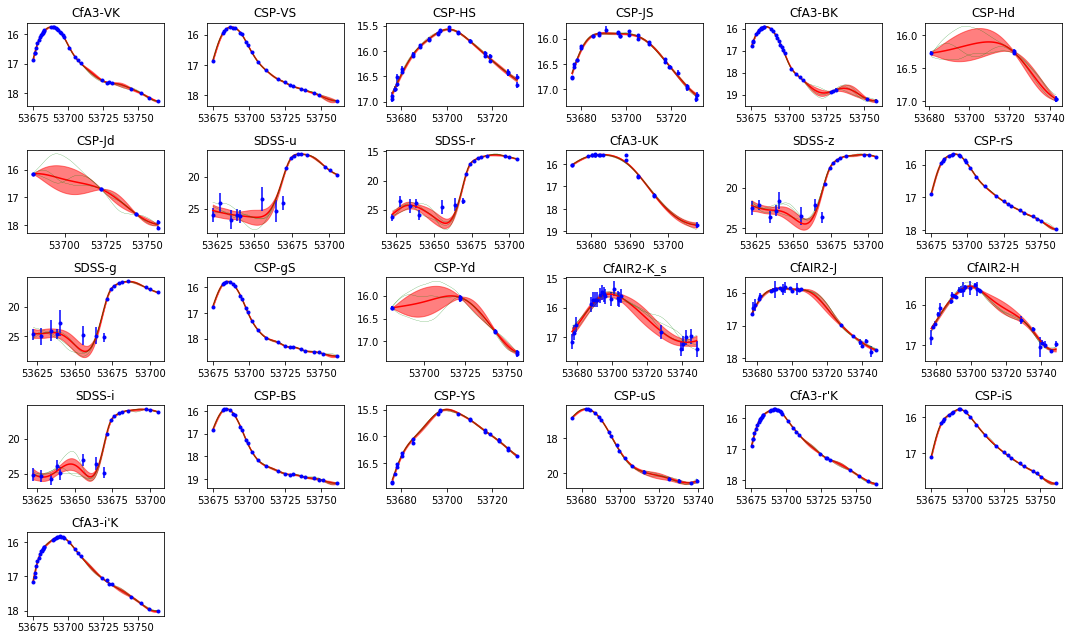

[53688.506061871958, 53687.76583250289, 53700.754729275191, 53690.196393737526, 53684.550366151139, 53709.672149022299, 53683.121985493017, 53680.450998790089, 53690.563939236119, 53682.798156961457, 53696.739839727452, 53691.573672799037, 53686.006085534988, 53685.401013256407, 53716.46519561622, 53698.360332908225, 53693.877046316855, 53699.183581801946, 53695.997923376854, 53684.652947632261, 53699.948393094426, 53682.248286456183, 53691.659376983043, 53694.688805761929, 53694.211260905213]
['CfA3-VK', 'CSP-VS', 'CSP-HS', 'CSP-JS', 'CfA3-BK', 'CSP-Hd', 'CSP-Jd', 'SDSS-u', 'SDSS-r', 'CfA3-UK', 'SDSS-z', 'CSP-rS', 'SDSS-g', 'CSP-gS', 'CSP-Yd', 'CfAIR2-K_s', 'CfAIR2-J', 'CfAIR2-H', 'SDSS-i', 'CSP-BS', 'CSP-YS', 'CSP-uS', "CfA3-r'K", 'CSP-iS', "CfA3-i'K"]
Effective wavelength of bessellb: 4384.77273446
wavelength difference: -36.0419272146
peakmjd: 53684.6529476


In [23]:
reload(sedfit.utils)

# sn = phot[phot['Survey'] == 'CSP'].copy()
sn = phot.copy()

z = redshift

sedfit.utils.register_bands_for_sncosmo()

gpfit_result = sedfit.utils.fit_gp(sn)

plt.show()

gpmeanlc = gpfit_result.meanlc
gpmeanlc_cov = gpfit_result.meanlc_cov
gppeakmjds = gpfit_result.peakmjds
gpfilters = gpfit_result.filters

print gppeakmjds
print gpfilters

peakmjd = sedfit.utils.get_b_band_peakmjd(gpfilters,gppeakmjds,z)
print "peakmjd:", peakmjd
if np.sum(peakmjd>0) == 0:
    print "Can not estimate peak in any band. Stop."


['CSP-BS', 'CSP-HS', 'CSP-Hd', 'CSP-JS', 'CSP-Jd', 'CSP-VS', 'CSP-YS', 'CSP-Yd', 'CSP-gS', 'CSP-iS', 'CSP-rS', 'CSP-uS', 'SDSS-z']


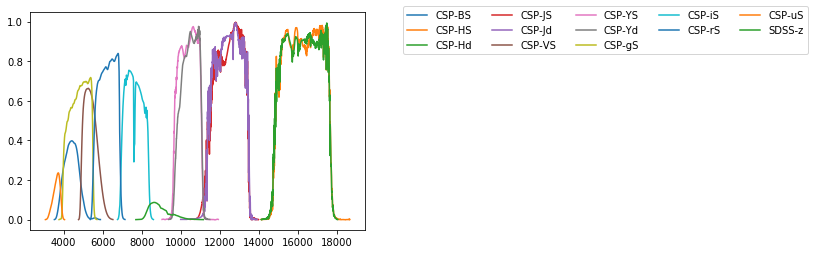

In [24]:
#plot filters
filters = np.unique(sn['Filter'][sn['Survey']=='CSP']).tolist()
filters += ['SDSS-z']

sedfit.utils.register_bands_for_sncosmo()

for f in filters:
    band = sncosmo.get_bandpass(f)
    plt.plot(band.wave,band.trans,label=f)
plt.legend(bbox_to_anchor=(1.1, 1.05),ncol=5)
print filters

In [25]:
(spectra['time']-peakmjd)/(1.+z)

0      -9.340955
1      -8.541397
2      -8.343975
3      -8.324233
4      -7.554289
5      -7.337125
6      -6.567180
7      -6.567180
8      -6.310532
9      -5.580072
10     -5.580072
11     -5.362908
12     -4.592964
13     -4.592964
14     -4.375800
15     -4.296831
16     -3.605855
17     -3.408433
18     -3.378820
19     -2.421325
20     -2.421325
21     -1.414475
22      3.303903
23     12.187879
24     14.162095
25     14.379259
26     20.282167
27     21.861541
28     23.046071
29     23.194137
30     23.342203
31     26.007396
32     27.112957
33     36.865588
34     38.839805
35     41.801130
36     42.788238
37     50.882527
38     53.646430
39     65.491730
40     73.487308
41    372.679853
42    402.293104
43    454.609848
Name: time, dtype: float64

In [26]:
spectra_orig = spectra.copy()

In [27]:
## throw out and combine some spectra with close phases
pthreshold = 0.5
drop_indices = []
newspectra = spectra_orig.iloc[0].copy()
for i,s in enumerate(spectra_orig.iterrows()):
#     print i
    if i == 0:
        continue

    spectrum = s[1]
    phase = spectrum['time']
    sdata = pd.DataFrame(spectrum['data'])
    wave = np.array(sdata[0].astype(float))
    flux = np.array(sdata[1].astype(float))
    
    spectrum_prev = spectra_orig.iloc[i-1]
    phase_prev = spectrum_prev['time']
    sdata_prev = pd.DataFrame(spectrum_prev['data'])
    wave_prev = np.array(sdata_prev[0].astype(float))
    flux_prev = np.array(sdata_prev[1].astype(float))    
    
    dphase = phase-phase_prev
    
    if np.abs(dphase) < pthreshold:
#         print phase,wave[0],wave[-1]
#         print phase_prev,wave_prev[0],wave_prev[-1]
        if (wave[0]-wave_prev[0])*(wave[-1]-wave_prev[-1]) > 0:
            if wave[0] < wave_prev[0]:
                idxl = np.argmin(np.abs(wave-wave_prev[0]))
                idxr = np.argmin(np.abs(wave-wave_prev[-1]))
                newwave = np.concatenate((wave[0:idxl],wave_prev),axis=0)
                scale = flux_prev[0]/flux[idxl]
                newflux = np.concatenate((flux[0:idxl]*scale,flux_prev),axis=0)
                newphase = np.mean([phase_prev,phase])
                newspectrum = spectrum_prev.copy()
                newspectrum['time'] = newphase
                newspectrum['data'] = zip(newwave,newflux)
            else:
                idxl = np.argmin(np.abs(wave_prev-wave[0]))
                idxr = np.argmin(np.abs(wave_prev-wave[-1]))
                newwave = np.concatenate((wave_prev[0:idxl],wave),axis=0)
                scale = flux[0]/flux_prev[idxl]
                newflux = np.concatenate((flux_prev[0:idxl]*scale,flux),axis=0)
                newphase = np.mean([phase_prev,phase])
                newspectrum = spectrum.copy()
                newspectrum['time'] = newphase
                newspectrum['data'] = zip(newwave,newflux)
#             print newphase
            drop_indices+=[i-1,i]
            newspectra = pd.concat([newspectra,newspectrum],ignore_index=True,axis=1)
#             plt.plot(newwave,newflux)
#             plt.show()
        else:
            if wave[0] < wave_prev[0]:
                drop_indices.append(i-1)
            else:
                drop_indices.append(i)   
newspectra = newspectra.transpose().iloc[1:]
drop_indices = np.unique(drop_indices).tolist()
print drop_indices
spectra = spectra_orig.drop(drop_indices)
spectra = pd.concat([spectra,newspectra])
spectra = spectra.sort_values(by=['time'])
spectra = spectra.reset_index()

[1, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 29]


In [28]:
# print (spectra['time']-peakmjd)/(1.+z)

In [29]:
## fit to blackbody
from astropy.modeling.blackbody import blackbody_lambda
from scipy.optimize import curve_fit
def bbfunc(wave,temp=7000,amp=1):
    flux = blackbody_lambda(wave,temp).value
    return amp*flux
def fit_blackbody(wave,obsflux,temp_init = 7000,amp_init=1):
    res = curve_fit(bbfunc, wave, obsflux, p0=[temp_init,amp_init],bounds=(0.,np.inf))
    return res 

In [30]:
# norm_par = np.power(10.,-12)
# hflux_norm = hflux/norm_par
# popt, pcov = fit_blackbody(hwave,hflux_norm)
# print "bbfit:",popt

# plt.plot(hwave,bbfunc(hwave,popt[0],popt[1]*norm_par*scale))



bessellb scale= 340167113.294
bessellv scale= 348490450.642
bessellr scale= 353415207.397
besselli scale= 380166504.356


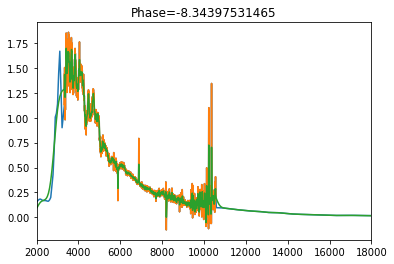

bessellb scale= 3.99218000081e-07
bessellv scale= 4.30448388879e-07
bessellr scale= 4.79899680574e-07
besselli scale= 5.16389631779e-07


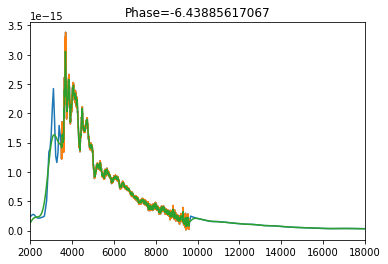

bessellb scale= 385736325.061
bessellv scale= 475355038.279
bessellr scale= 513870211.15
besselli scale= 586904370.667


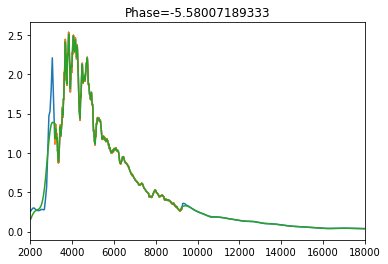

bessellb scale= 3.85395885186e-07
bessellv scale= 4.44125020514e-07
bessellr scale= 4.78644747178e-07
besselli scale= 5.43403170873e-07


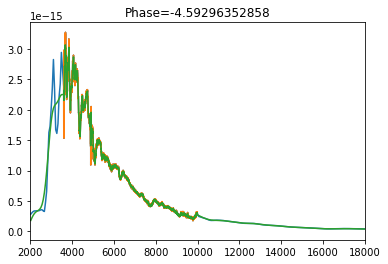

bessellb scale= 3.7482348416e-07
bessellv scale= 4.36661031002e-07
bessellr scale= 4.75864667063e-07
besselli scale= 5.46083094715e-07


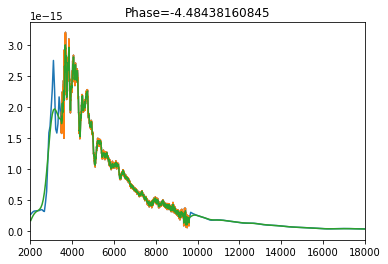

bessellb scale= 139977665658.0
bessellv scale= 150697930051.0
bessellr scale= 161850847713.0
besselli scale= 189291111090.0


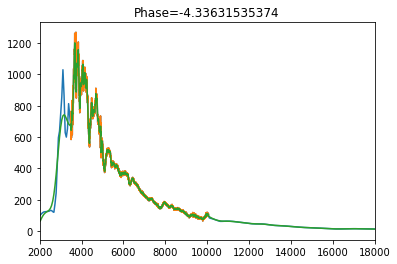

bessellb scale= 6996645260.18
bessellv scale= 7363271742.93
bessellr scale= 7891480948.04
besselli scale= 9266873179.57


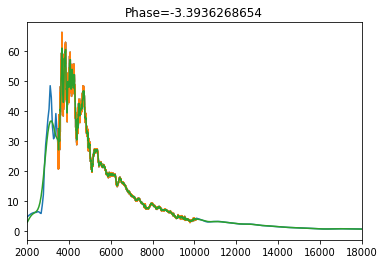

bessellb scale= 7057628218.22
bessellv scale= 7780467778.14
bessellr scale= 8584268093.62
besselli scale= 10887824904.9


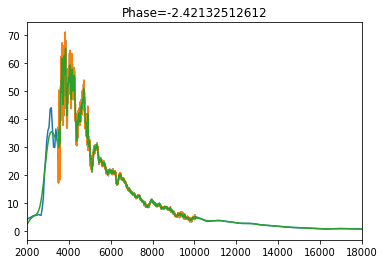

bessellv scale= 5.10727892606e-07
bessellv scale= 5.13907092419e-07
bessellb scale= 2.4706748505e-07
bessellv scale= 4.98616519562e-07
bessellr scale= 8.81363233924e-07
besselli scale= 1.56843920466e-06


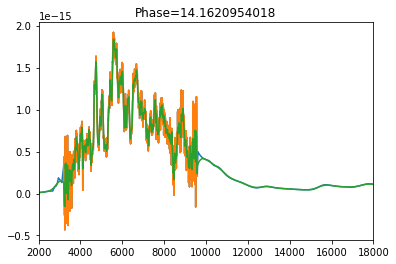

bessellv scale= 19847434.0035
bessellr scale= 31145280.4067
besselli scale= 45323754.286


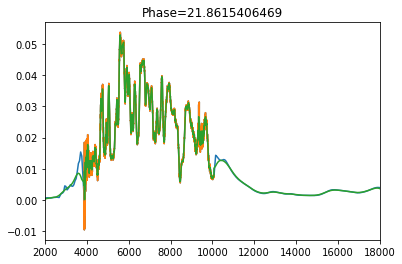

bessellb scale= 2.68684405292e-07
bessellv scale= 4.31897945622e-07
bessellr scale= 6.3602992954e-07
besselli scale= 9.17069869004e-07


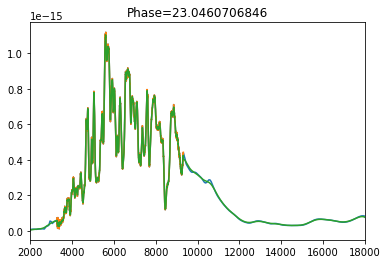

bessellb scale= 255591531.167
bessellv scale= 432694011.327
bessellr scale= 643846626.524
besselli scale= 897686540.45


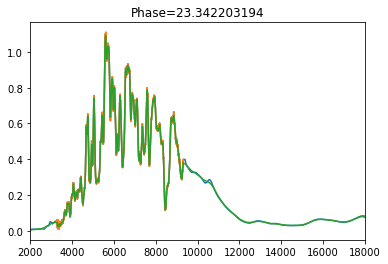

bessellv scale= 5.8079142324e-07
bessellr scale= 7.10408534176e-07
besselli scale= 7.77082134362e-07


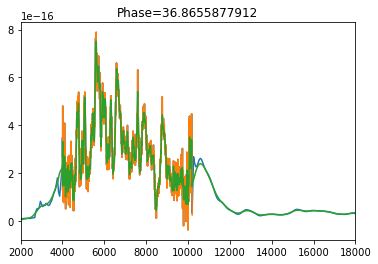

bessellv scale= 6.00942233881e-07
bessellr scale= 7.55367073784e-07
besselli scale= 8.61673879284e-07


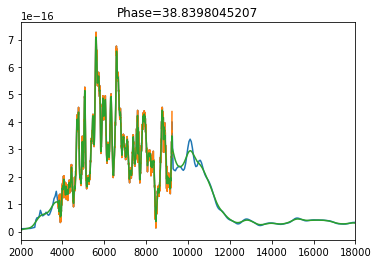

bessellv scale= 6.34749054375e-07
bessellr scale= 7.84697036262e-07
besselli scale= 9.48270731531e-07


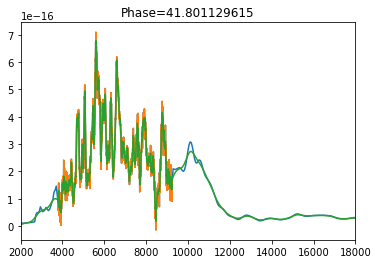

bessellv scale= 6.38440760222e-07
bessellr scale= 7.88478105276e-07
besselli scale= 9.90973801983e-07


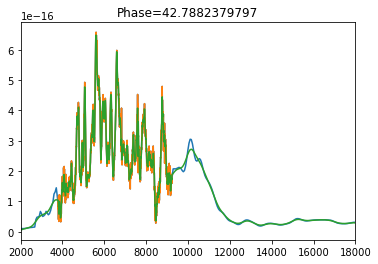

bessellv scale= 3769615706.31
bessellr scale= 4634913751.75


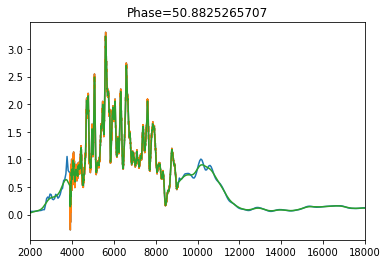

bessellv scale= 7.62168040668e-07
bessellr scale= 9.63792853074e-07
besselli scale= 1.48426323841e-06


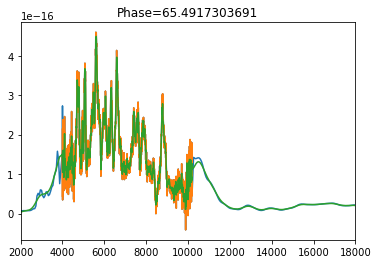

bessellb scale= 6287433.81628
bessellv scale= 16482164.6707
bessellr scale= 36818169.1352
besselli scale= 97572700.0084


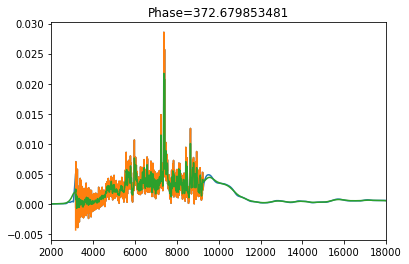

(19, 14)


In [31]:
## Extend spectra using Hsiao model

minw = 4000
maxw = 8000
hminw = 2000
hmaxw = 18000
outphases = []
spectra_extended = spectra.iloc[0].copy()

for i,s in enumerate(spectra.iterrows()):
   
    spectrum = s[1]
    phase = (spectrum['time']-peakmjd)/(1.+ z)

    sdata = pd.DataFrame(spectrum['data'])
    wave = np.array(sdata[0].astype(float))
    flux = np.atleast_2d(sdata[1].astype(float))
   
    minwave = wave.min()
    maxwave = wave.max()
    
    if phase < 0 or phase > 15:
        if minwave>minw or maxwave<maxw:
            continue

    nrepeat = 5
    phasearr = np.linspace(-50.,100.,nrepeat)
    
    newsource = sncosmo.TimeSeriesSource(phasearr,wave,np.repeat(flux,nrepeat,axis=0))
    newsed_at_p = sncosmo.Model(newsource)
    
    hsed = sncosmo.Model(source='hsiao')
    hsed.set(z=redshift)
    hwave = np.linspace(hminw*(1.+redshift),hmaxw*(1.+redshift),300)
    hflux = hsed.flux(phase,hwave)
    
    scales = []
    for b in ['B','V','R','I']:
        band = sncosmo.get_bandpass('Bessell'+b)
        if wave.min() > band.wave.min() or wave.max()< band.wave.max():
            continue
        synmag = newsed_at_p.bandmag(band,'ab',phase)
        hsynmag = hsed.bandmag(band,'ab',phase)
        scale = np.power(10.,-0.4*(synmag-hsynmag))
        print band.name,"scale=",scale
        scales.append(scale)
    
    if len(scales) <=1:
        continue
    
    idxl = np.argmin(np.abs(hwave-wave[0]))
    idxr = np.argmin(np.abs(hwave-wave[-1]))
    newwave = np.concatenate((hwave[:idxl-1],wave[1:-1],hwave[idxr+1:]),axis=0)
    newflux = np.concatenate((hflux[:idxl-1]*scales[0],flux.ravel()[1:-1],hflux[idxr+1:]*scales[-1]),axis=0)
    
    plt.plot(newwave,newflux)
    plt.plot(wave,flux.ravel())
    plt.title("Phase={}".format(phase))      
    
    ##smooth the spectra
    g = Gaussian1DKernel(stddev=3)
    newflux_smoothed = convolve(newflux, g)    
    
    plt.plot(newwave,newflux_smoothed)
    
    newspectrum = spectrum.copy()
    newspectrum['data'] = zip(newwave,newflux_smoothed)
        
    spectra_extended = pd.concat([spectra_extended,newspectrum],ignore_index=True,axis=1)  
      
#     plt.plot(hwave,hflux*scales[0],label='uv')
#     plt.plot(hwave,hflux*scales[-1],label='ir')
#     plt.legend()

    plt.xlim(hminw,hmaxw)
#     plt.xlim(2000,5000)
    plt.show()

    outphases.append(phase)
spectra_extended = spectra_extended.transpose().iloc[1:]
print spectra_extended.shape

In [32]:
# print len(outphases)
# print outphases

Phase= -8.34397531465
['CSP-BS', 'CSP-HS', 'CSP-Hd', 'CSP-JS', 'CSP-Jd', 'CSP-VS', 'CSP-YS', 'CSP-Yd', 'CSP-gS', 'CSP-iS', 'CSP-rS', 'CSP-uS', 'SDSS-z']
Phase 53676.2 out of data range [53681.08,53743.07].
Phase 53676.2 out of data range [53681.08,53756.07].
Phase 53676.2 out of data range [53681.08,53756.07].
Bands are out of range ['CSP-HS']
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS']
efflam =  [  3628.67221495   4405.52523159   4794.04150564   5389.26524088
   6239.34112913   7630.76341788   8918.30148441  10388.61644953
  12452.52755988]
Phase = -8.34397531465
Phot_at_p:
    Phase      Filter      Mag           MagErr     sortid
-------------- ------ ------------- --------------- ------
-8.34397531465 CSP-uS 16.6816336066  0.024058873165      0
-8.34397531465 CSP-BS 16.6534433397 0.0157243708867      1
-8.34397531465 CSP-gS 16.5835267626 0.0137863625331      2
-8.34397531465 CSP-VS  16.686417188 0.0131834450703      3
-8.3439

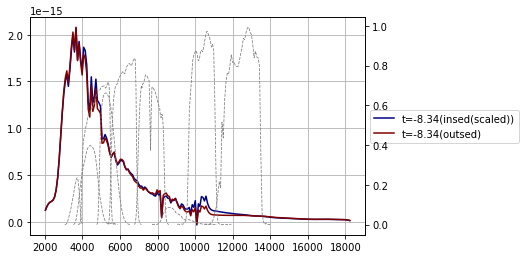

Phase= -6.43885617067
['CSP-BS', 'CSP-HS', 'CSP-Hd', 'CSP-JS', 'CSP-Jd', 'CSP-VS', 'CSP-YS', 'CSP-Yd', 'CSP-gS', 'CSP-iS', 'CSP-rS', 'CSP-uS', 'SDSS-z']
Phase 53678.13 out of data range [53681.08,53743.07].
Phase 53678.13 out of data range [53681.08,53756.07].
Phase 53678.13 out of data range [53681.08,53756.07].
Bands are out of range ['CSP-HS']
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS']
efflam =  [  3628.67221495   4405.52523159   4794.04150564   5389.26524088
   6239.34112913   7630.76341788   8918.30148441  10388.61644953
  12452.52755988]
Phase = -6.43885617067
Phot_at_p:
    Phase      Filter      Mag           MagErr      sortid
-------------- ------ ------------- ---------------- ------
-6.43885617067 CSP-uS 16.4928675917  0.0350821474491      0
-6.43885617067 CSP-BS  16.367316126  0.0226218389931      1
-6.43885617067 CSP-gS 16.2950066311  0.0195071768358      2
-6.43885617067 CSP-VS 16.3893955844  0.0179613350343      

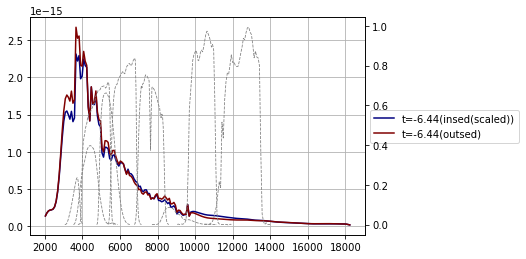

Phase= -5.58007189333
['CSP-BS', 'CSP-HS', 'CSP-Hd', 'CSP-JS', 'CSP-Jd', 'CSP-VS', 'CSP-YS', 'CSP-Yd', 'CSP-gS', 'CSP-iS', 'CSP-rS', 'CSP-uS', 'SDSS-z']
Phase 53679.0 out of data range [53681.08,53743.07].
Phase 53679.0 out of data range [53681.08,53756.07].
Phase 53679.0 out of data range [53681.08,53756.07].
Bands are out of range ['CSP-HS']
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS']
efflam =  [  3628.67221495   4405.52523159   4794.04150564   5389.26524088
   6239.34112913   7630.76341788   8918.30148441  10388.61644953
  12452.52755988]
Phase = -5.58007189333
Phot_at_p:
    Phase      Filter      Mag           MagErr     sortid
-------------- ------ ------------- --------------- ------
-5.58007189333 CSP-uS 16.4260261458 0.0331249527418      0
-5.58007189333 CSP-BS 16.2550707283 0.0206056102455      1
-5.58007189333 CSP-gS 16.1798365827  0.017533270096      2
-5.58007189333 CSP-VS 16.2688241214 0.0166310345398      3
-5.5800

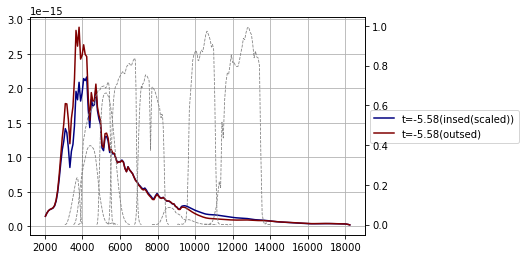

Phase= -4.59296352858
['CSP-BS', 'CSP-HS', 'CSP-Hd', 'CSP-JS', 'CSP-Jd', 'CSP-VS', 'CSP-YS', 'CSP-Yd', 'CSP-gS', 'CSP-iS', 'CSP-rS', 'CSP-uS', 'SDSS-z']
Phase 53680.0 out of data range [53681.08,53743.07].
Phase 53680.0 out of data range [53681.08,53756.07].
Phase 53680.0 out of data range [53681.08,53756.07].
Bands are out of range ['CSP-HS']
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS']
efflam =  [  3628.67221495   4405.52523159   4794.04150564   5389.26524088
   6239.34112913   7630.76341788   8918.30148441  10388.61644953
  12452.52755988]
Phase = -4.59296352858
Phot_at_p:
    Phase      Filter      Mag           MagErr      sortid
-------------- ------ ------------- ---------------- ------
-4.59296352858 CSP-uS 16.3666516553  0.0271145350904      0
-4.59296352858 CSP-BS 16.1430754174  0.0158595805858      1
-4.59296352858 CSP-gS 16.0630525825  0.0131235727328      2
-4.59296352858 CSP-VS 16.1444736772  0.0132468880651      3
-

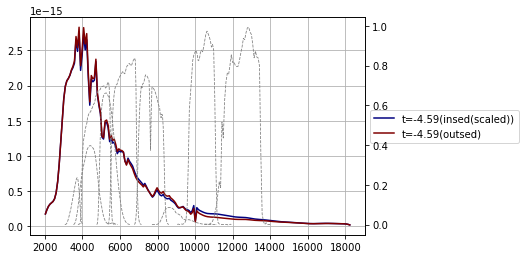

Phase= -4.48438160845
['CSP-BS', 'CSP-HS', 'CSP-Hd', 'CSP-JS', 'CSP-Jd', 'CSP-VS', 'CSP-YS', 'CSP-Yd', 'CSP-gS', 'CSP-iS', 'CSP-rS', 'CSP-uS', 'SDSS-z']
Phase 53680.11 out of data range [53681.08,53743.07].
Phase 53680.11 out of data range [53681.08,53756.07].
Phase 53680.11 out of data range [53681.08,53756.07].
Bands are out of range ['CSP-HS']
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS']
efflam =  [  3628.67221495   4405.52523159   4794.04150564   5389.26524088
   6239.34112913   7630.76341788   8918.30148441  10388.61644953
  12452.52755988]
Phase = -4.48438160845
Phot_at_p:
    Phase      Filter      Mag           MagErr      sortid
-------------- ------ ------------- ---------------- ------
-4.48438160845 CSP-uS 16.3613538452  0.0262930852063      0
-4.48438160845 CSP-BS 16.1319830809   0.015248055976      1
-4.48438160845 CSP-gS 16.0513401702  0.0125611728463      2
-4.48438160845 CSP-VS 16.1318268342  0.0127999087905      

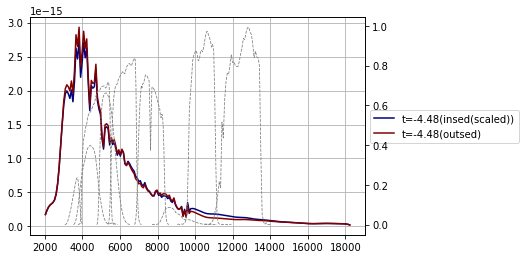

Phase= -4.33631535374
['CSP-BS', 'CSP-HS', 'CSP-Hd', 'CSP-JS', 'CSP-Jd', 'CSP-VS', 'CSP-YS', 'CSP-Yd', 'CSP-gS', 'CSP-iS', 'CSP-rS', 'CSP-uS', 'SDSS-z']
Phase 53680.26 out of data range [53681.08,53743.07].
Phase 53680.26 out of data range [53681.08,53756.07].
Phase 53680.26 out of data range [53681.08,53756.07].
Bands are out of range ['CSP-HS']
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS']
efflam =  [  3628.67221495   4405.52523159   4794.04150564   5389.26524088
   6239.34112913   7630.76341788   8918.30148441  10388.61644953
  12452.52755988]
Phase = -4.33631535374
Phot_at_p:
    Phase      Filter      Mag           MagErr      sortid
-------------- ------ ------------- ---------------- ------
-4.33631535374 CSP-uS 16.3545390481  0.0251411577026      0
-4.33631535374 CSP-BS 16.1172686135   0.014400401802      1
-4.33631535374 CSP-gS 16.0357503066  0.0117830975436      2
-4.33631535374 CSP-VS 16.1149263335  0.0121768978304      

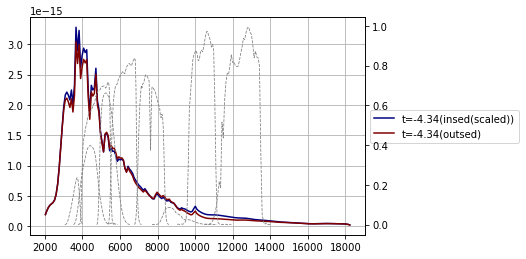

Phase= -3.3936268654
['CSP-BS', 'CSP-HS', 'CSP-Hd', 'CSP-JS', 'CSP-Jd', 'CSP-VS', 'CSP-YS', 'CSP-Yd', 'CSP-gS', 'CSP-iS', 'CSP-rS', 'CSP-uS', 'SDSS-z']
Bands are out of range ['CSP-HS']
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS']
efflam =  [  3628.67221495   4405.52523159   4794.04150564   5389.26524088
   6239.34112913   7630.76341788   8918.30148441  10388.61644953
  12452.52755988]
Phase = -3.3936268654
Phot_at_p:
    Phase     Filter      Mag           MagErr      sortid
------------- ------ ------------- ---------------- ------
-3.3936268654 CSP-uS 16.3225263045  0.0175140109281      0
-3.3936268654 CSP-BS 16.0350991108 0.00902735560247      1
-3.3936268654 CSP-gS 15.9471985963 0.00690422951796      2
-3.3936268654 CSP-VS 16.0169165004  0.0081363035414      3
-3.3936268654 CSP-rS 16.0216482489 0.00708328181951      4
-3.3936268654 CSP-iS 16.2476209493 0.00690156360787      5
-3.3936268654 SDSS-z 16.3554889295 0.0084138570276

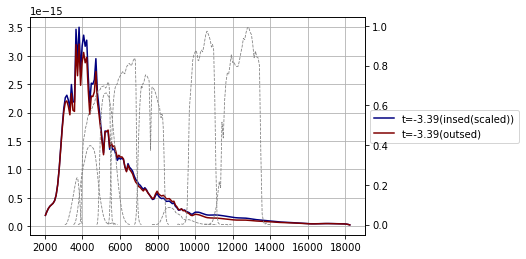

Phase= -2.42132512612
['CSP-BS', 'CSP-HS', 'CSP-Hd', 'CSP-JS', 'CSP-Jd', 'CSP-VS', 'CSP-YS', 'CSP-Yd', 'CSP-gS', 'CSP-iS', 'CSP-rS', 'CSP-uS', 'SDSS-z']
Bands are out of range ['CSP-HS']
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS']
efflam =  [  3628.67221495   4405.52523159   4794.04150564   5389.26524088
   6239.34112913   7630.76341788   8918.30148441  10388.61644953
  12452.52755988]
Phase = -2.42132512612
Phot_at_p:
    Phase      Filter      Mag           MagErr      sortid
-------------- ------ ------------- ---------------- ------
-2.42132512612 CSP-uS 16.3106483849  0.0111878196911      0
-2.42132512612 CSP-BS 15.9719347127 0.00484176503543      1
-2.42132512612 CSP-gS 15.8759777136 0.00348277965026      2
-2.42132512612 CSP-VS 15.9334413413 0.00485412387731      3
-2.42132512612 CSP-rS 15.9384855792  0.0042115281082      4
-2.42132512612 CSP-iS 16.1647461017 0.00434740483637      5
-2.42132512612 SDSS-z  16.271711981  0.0

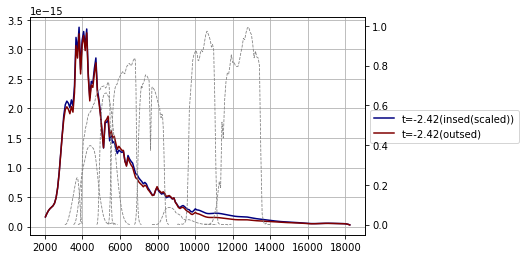

Phase= 14.1620954018
['CSP-BS', 'CSP-HS', 'CSP-Hd', 'CSP-JS', 'CSP-Jd', 'CSP-VS', 'CSP-YS', 'CSP-Yd', 'CSP-gS', 'CSP-iS', 'CSP-rS', 'CSP-uS', 'SDSS-z']
Bands are out of range ['CSP-HS']
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS']
efflam =  [  3628.67221495   4405.52523159   4794.04150564   5389.26524088
   6239.34112913   7630.76341788   8918.30148441  10388.61644953
  12452.52755988]
Phase = 14.1620954018
Phot_at_p:
    Phase     Filter      Mag           MagErr      sortid
------------- ------ ------------- ---------------- ------
14.1620954018 CSP-uS 18.6068898072  0.0287580764515      0
14.1620954018 CSP-BS 17.4112491849 0.00635069189091      1
14.1620954018 CSP-gS 16.9467692847 0.00363626504527      2
14.1620954018 CSP-VS 16.3155971357 0.00452903830249      3
14.1620954018 CSP-rS 15.9174859626 0.00290183510833      4
14.1620954018 CSP-iS 15.8727316267 0.00387050067821      5
14.1620954018 SDSS-z 15.9373332412  0.016480942450

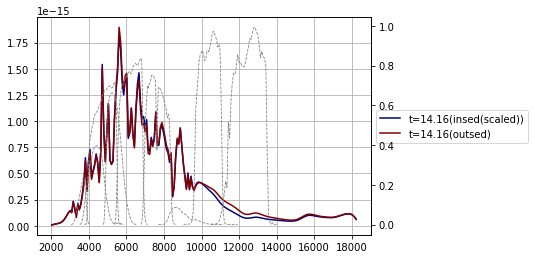

Phase= 21.8615406469
['CSP-BS', 'CSP-HS', 'CSP-Hd', 'CSP-JS', 'CSP-Jd', 'CSP-VS', 'CSP-YS', 'CSP-Yd', 'CSP-gS', 'CSP-iS', 'CSP-rS', 'CSP-uS', 'SDSS-z']
Phase 53706.8 out of data range [53622.3476562,53705.234375].
Bands are out of range ['CSP-HS']
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'CSP-YS', 'CSP-JS']
efflam =  [  3628.67221495   4405.52523159   4794.04150564   5389.26524088
   6239.34112913   7630.76341788  10388.61644953  12452.52755988]
Phase = 21.8615406469
Phot_at_p:
    Phase     Filter      Mag           MagErr      sortid
------------- ------ ------------- ---------------- ------
21.8615406469 CSP-uS 19.6348644332  0.0581728215937      0
21.8615406469 CSP-BS 18.2049668846  0.0150583260133      1
21.8615406469 CSP-gS  17.694658211 0.00875720361588      2
21.8615406469 CSP-VS 16.9245688095 0.00929016591464      3
21.8615406469 CSP-rS 16.4118135657 0.00904653497036      4
21.8615406469 CSP-iS 16.2422511988 0.00890769895876      5
21.8615406469 C

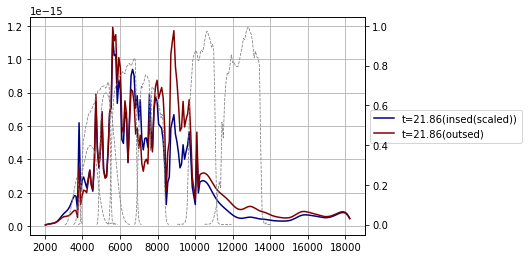

Phase= 23.0460706846
['CSP-BS', 'CSP-HS', 'CSP-Hd', 'CSP-JS', 'CSP-Jd', 'CSP-VS', 'CSP-YS', 'CSP-Yd', 'CSP-gS', 'CSP-iS', 'CSP-rS', 'CSP-uS', 'SDSS-z']
Phase 53708.0 out of data range [53622.3476562,53705.234375].
Bands are out of range ['CSP-HS']
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'CSP-YS', 'CSP-JS']
efflam =  [  3628.67221495   4405.52523159   4794.04150564   5389.26524088
   6239.34112913   7630.76341788  10388.61644953  12452.52755988]
Phase = 23.0460706846
Phot_at_p:
    Phase     Filter      Mag           MagErr     sortid
------------- ------ ------------- --------------- ------
23.0460706846 CSP-uS 19.7222583188 0.0657569732134      0
23.0460706846 CSP-BS 18.2745318832 0.0177876767059      1
23.0460706846 CSP-gS 17.7697062286 0.0117485332552      2
23.0460706846 CSP-VS 16.9929531672  0.011329533573      3
23.0460706846 CSP-rS 16.4800385254 0.0106300241778      4
23.0460706846 CSP-iS 16.3029115309 0.0103278041299      5
23.0460706846 CSP-YS  1

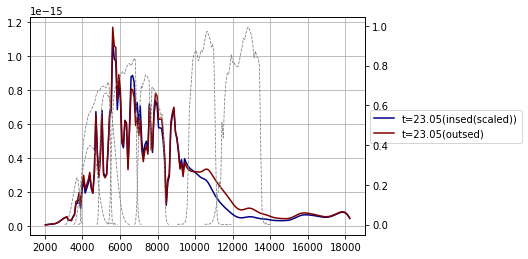

Phase= 23.342203194
['CSP-BS', 'CSP-HS', 'CSP-Hd', 'CSP-JS', 'CSP-Jd', 'CSP-VS', 'CSP-YS', 'CSP-Yd', 'CSP-gS', 'CSP-iS', 'CSP-rS', 'CSP-uS', 'SDSS-z']
Phase 53708.3 out of data range [53622.3476562,53705.234375].
Bands are out of range ['CSP-HS']
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'CSP-YS', 'CSP-JS']
efflam =  [  3628.67221495   4405.52523159   4794.04150564   5389.26524088
   6239.34112913   7630.76341788  10388.61644953  12452.52755988]
Phase = 23.342203194
Phot_at_p:
   Phase     Filter      Mag           MagErr     sortid
------------ ------ ------------- --------------- ------
23.342203194 CSP-uS 19.7418398581 0.0679133856399      0
23.342203194 CSP-BS 18.2898714446 0.0183417061971      1
23.342203194 CSP-gS 17.7871565281 0.0124094553452      2
23.342203194 CSP-VS 17.0089485048 0.0117497221427      3
23.342203194 CSP-rS 16.4961402267  0.010914511212      4
23.342203194 CSP-iS 16.3178456948 0.0105999804617      5
23.342203194 CSP-YS 15.6361501661

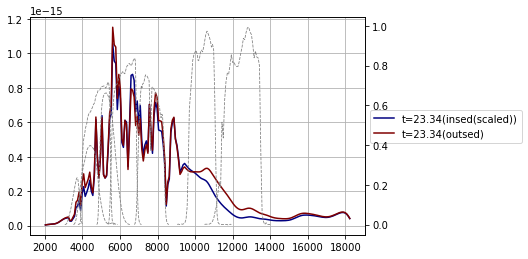

Phase= 36.8655877912
['CSP-BS', 'CSP-HS', 'CSP-Hd', 'CSP-JS', 'CSP-Jd', 'CSP-VS', 'CSP-YS', 'CSP-Yd', 'CSP-gS', 'CSP-iS', 'CSP-rS', 'CSP-uS', 'SDSS-z']
Phase 53722.0 out of data range [53622.3476562,53705.234375].
Bands are out of range ['CSP-HS']
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'CSP-YS', 'CSP-JS']
efflam =  [  3628.67221495   4405.52523159   4794.04150564   5389.26524088
   6239.34112913   7630.76341788  10388.61644953  12452.52755988]
Phase = 36.8655877912
Phot_at_p:
    Phase     Filter      Mag           MagErr      sortid
------------- ------ ------------- ---------------- ------
36.8655877912 CSP-uS  20.204091949   0.137313701807      0
36.8655877912 CSP-BS 18.7005705842  0.0232190924125      1
36.8655877912 CSP-gS  18.189718278  0.0134956633216      2
36.8655877912 CSP-VS 17.5101337835  0.0130605749402      3
36.8655877912 CSP-rS 17.0307154647  0.0083083802192      4
36.8655877912 CSP-iS 16.8786276588 0.00927128409787      5
36.8655877912 C

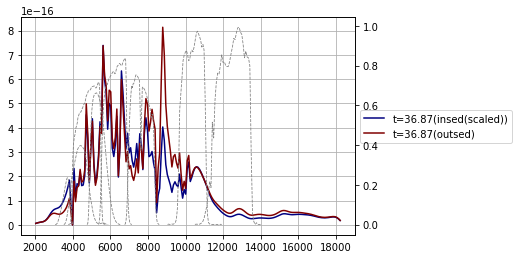

Phase= 38.8398045207
['CSP-BS', 'CSP-HS', 'CSP-Hd', 'CSP-JS', 'CSP-Jd', 'CSP-VS', 'CSP-YS', 'CSP-Yd', 'CSP-gS', 'CSP-iS', 'CSP-rS', 'CSP-uS', 'SDSS-z']
Phase 53724.0 out of data range [53622.3476562,53705.234375].
Bands are out of range ['CSP-HS']
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'CSP-YS', 'CSP-JS']
efflam =  [  3628.67221495   4405.52523159   4794.04150564   5389.26524088
   6239.34112913   7630.76341788  10388.61644953  12452.52755988]
Phase = 38.8398045207
Phot_at_p:
    Phase     Filter      Mag           MagErr      sortid
------------- ------ ------------- ---------------- ------
38.8398045207 CSP-uS 20.2652867866   0.113047315621      0
38.8398045207 CSP-BS 18.7487427617  0.0193196402664      1
38.8398045207 CSP-gS 18.2485376047  0.0115282566768      2
38.8398045207 CSP-VS  17.555533391  0.0116203844046      3
38.8398045207 CSP-rS 17.0926958759 0.00815661220278      4
38.8398045207 CSP-iS 16.9445402276 0.00929769866712      5
38.8398045207 C

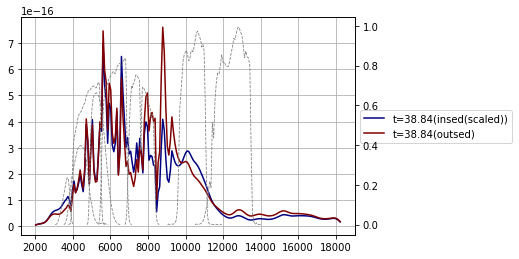

Phase= 41.801129615
['CSP-BS', 'CSP-HS', 'CSP-Hd', 'CSP-JS', 'CSP-Jd', 'CSP-VS', 'CSP-YS', 'CSP-Yd', 'CSP-gS', 'CSP-iS', 'CSP-rS', 'CSP-uS', 'SDSS-z']
Phase 53727.0 out of data range [53622.3476562,53705.234375].
Bands are out of range ['CSP-HS']
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'CSP-YS', 'CSP-JS']
efflam =  [  3628.67221495   4405.52523159   4794.04150564   5389.26524088
   6239.34112913   7630.76341788  10388.61644953  12452.52755988]
Phase = 41.801129615
Phot_at_p:
   Phase     Filter      Mag           MagErr      sortid
------------ ------ ------------- ---------------- ------
41.801129615 CSP-uS 20.3661482414   0.089927582485      0
41.801129615 CSP-BS 18.7953028346  0.0149513532249      1
41.801129615 CSP-gS 18.3104143958 0.00781995680197      2
41.801129615 CSP-VS 17.6306041045 0.00820368501421      3
41.801129615 CSP-rS 17.1779740823 0.00619593936119      4
41.801129615 CSP-iS 17.0377044259 0.00698612192879      5
41.801129615 CSP-YS 16.22

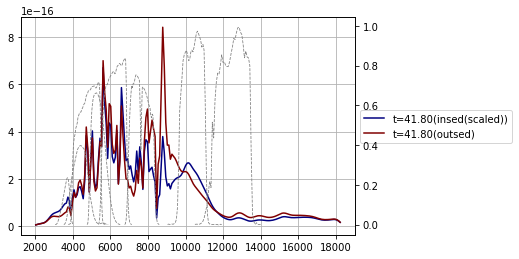

Phase= 42.7882379797
['CSP-BS', 'CSP-HS', 'CSP-Hd', 'CSP-JS', 'CSP-Jd', 'CSP-VS', 'CSP-YS', 'CSP-Yd', 'CSP-gS', 'CSP-iS', 'CSP-rS', 'CSP-uS', 'SDSS-z']
Phase 53728.0 out of data range [53622.3476562,53705.234375].
Bands are out of range ['CSP-HS']
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'CSP-YS', 'CSP-JS']
efflam =  [  3628.67221495   4405.52523159   4794.04150564   5389.26524088
   6239.34112913   7630.76341788  10388.61644953  12452.52755988]
Phase = 42.7882379797
Phot_at_p:
    Phase     Filter      Mag           MagErr      sortid
------------- ------ ------------- ---------------- ------
42.7882379797 CSP-uS 20.4003727132  0.0877205748418      0
42.7882379797 CSP-BS  18.802826632  0.0145188798642      1
42.7882379797 CSP-gS 18.3180140633 0.00701841844646      2
42.7882379797 CSP-VS 17.6552661941 0.00752310266855      3
42.7882379797 CSP-rS 17.2055744606 0.00574885312367      4
42.7882379797 CSP-iS  17.068072218 0.00632744459137      5
42.7882379797 C

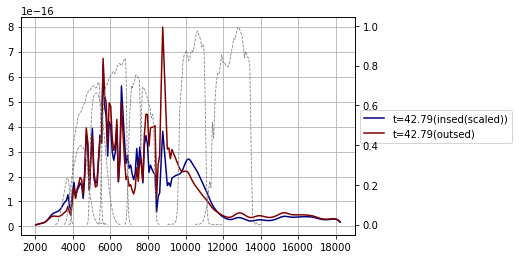

Phase= 50.8825265707
['CSP-BS', 'CSP-HS', 'CSP-Hd', 'CSP-JS', 'CSP-Jd', 'CSP-VS', 'CSP-YS', 'CSP-Yd', 'CSP-gS', 'CSP-iS', 'CSP-rS', 'CSP-uS', 'SDSS-z']
Phase 53736.2 out of data range [53676.0,53731.08].
Phase 53736.2 out of data range [53676.0,53731.08].
Phase 53736.2 out of data range [53676.0,53731.06].
Phase 53736.2 out of data range [53622.3476562,53705.234375].
Bands are out of range ['CSP-HS']
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS']
efflam =  [ 3628.67221495  4405.52523159  4794.04150564  5389.26524088  6239.34112913
  7630.76341788]
Phase = 50.8825265707
Phot_at_p:
    Phase     Filter      Mag           MagErr      sortid
------------- ------ ------------- ---------------- ------
50.8825265707 CSP-uS  20.530180097    0.05829573861      0
50.8825265707 CSP-BS 18.8794867362  0.0132844343899      1
50.8825265707 CSP-gS 18.4127948452 0.00653099390961      2
50.8825265707 CSP-VS 17.7922353541 0.00808968907464      3
50.8825265707 CSP-rS 17.4024932375 

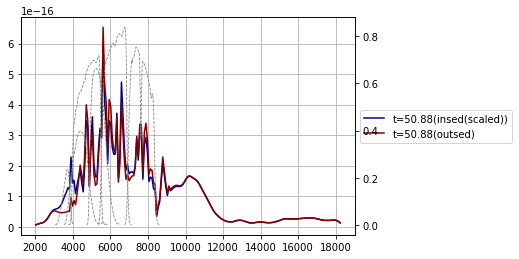

Phase= 65.4917303691
['CSP-BS', 'CSP-HS', 'CSP-Hd', 'CSP-JS', 'CSP-Jd', 'CSP-VS', 'CSP-YS', 'CSP-Yd', 'CSP-gS', 'CSP-iS', 'CSP-rS', 'CSP-uS', 'SDSS-z']
Phase 53751.0 out of data range [53676.0,53731.08].
Phase 53751.0 out of data range [53681.08,53743.07].
Phase 53751.0 out of data range [53676.0,53731.08].
Phase 53751.0 out of data range [53676.0,53731.06].
Phase 53751.0 out of data range [53675.11,53739.06].
Phase 53751.0 out of data range [53622.3476562,53705.234375].
Bands are out of range ['CSP-HS']
Filters:  ['CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS']
efflam =  [ 4405.52523159  4794.04150564  5389.26524088  6239.34112913  7630.76341788]
Phase = 65.4917303691
Phot_at_p:
    Phase     Filter      Mag           MagErr     sortid
------------- ------ ------------- --------------- ------
65.4917303691 CSP-BS 19.0674087191 0.0265990254893      0
65.4917303691 CSP-gS 18.5709293339 0.0105403900157      1
65.4917303691 CSP-VS 18.0543820901 0.0471468953087      2
65.4917303691 CSP-r

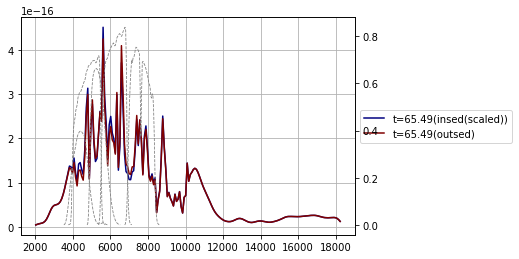

Phase= 372.679853481
['CSP-BS', 'CSP-HS', 'CSP-Hd', 'CSP-JS', 'CSP-Jd', 'CSP-VS', 'CSP-YS', 'CSP-Yd', 'CSP-gS', 'CSP-iS', 'CSP-rS', 'CSP-uS', 'SDSS-z']
Phase 54062.2 out of data range [53675.11,53761.04].
Phase 54062.2 out of data range [53676.0,53731.08].
Phase 54062.2 out of data range [53681.08,53743.07].
Phase 54062.2 out of data range [53676.0,53731.08].
Phase 54062.2 out of data range [53681.08,53756.07].
Phase 54062.2 out of data range [53675.11,53761.04].
Phase 54062.2 out of data range [53676.0,53731.06].
Phase 54062.2 out of data range [53681.08,53756.07].
Phase 54062.2 out of data range [53675.11,53761.04].
Phase 54062.2 out of data range [53675.11,53761.04].
Phase 54062.2 out of data range [53675.11,53761.04].
Phase 54062.2 out of data range [53675.11,53739.06].
Phase 54062.2 out of data range [53622.3476562,53705.234375].
Number of available bands is < 2. Skip this phase.


In [33]:
##mangle the spectra
reload(sedfit.mangle)

sedres = []
for s in spectra_extended.iterrows():
# for s in spectra_orig.iterrows():
    
    spectrum = s[1]
      
    phase = (spectrum['time']-peakmjd)/(1.+ z)
    print "Phase=",phase
    
    mags = []
    magerr = []
    goodfilts = []
    print filters
    for i,f in enumerate(filters):
#             print peakmjd
        mjd = phase*(1.+z)+peakmjd
        gpidx = gpfilters.index(f)
        mag = gpmeanlc[gpidx](mjd)
        merr = np.sqrt(gpmeanlc_cov[gpidx](mjd))
        mags.append(mag)
        magerr.append(merr)
        fminmjd = np.min(sn['MJD'][sn['Filter']==f])
        fmaxmjd = np.max(sn['MJD'][sn['Filter']==f])        
        
        if mjd < fminmjd  or mjd > fmaxmjd:
            print "Phase {} out of data range [{},{}].".format(mjd,fminmjd,fmaxmjd)
            goodfilts.append(False)
        else:
            goodfilts.append(True)
    goodfilts = np.array(goodfilts)

    phases = [phase]*len(filters)
    data_table = zip(mags,magerr,filters,phases)      
    synlc = Table(rows = data_table,names=('Mag','MagErr','Filter','Phase'),dtype=('f8', 'f8', 'S30','f8'))
    synlc_good = synlc[goodfilts]
    
    if len(synlc_good) < 2:
        print "Number of available bands is < 2. Skip this phase."
        continue

    nrepeat = 5
    phase = np.linspace(-50.,50.,nrepeat)

    sdata = pd.DataFrame(spectrum['data'])

    wave = np.array(sdata[0].astype(float))
    flux = np.atleast_2d(sdata[1].astype(float))

#     plt.plot(wave,flux.ravel())

    newsource = sncosmo.TimeSeriesSource(phase,wave,np.repeat(flux,nrepeat,axis=0))
    newsed_at_p = sncosmo.Model(newsource)
    
    excl_fs = []
    for f in filters:
        band = sncosmo.get_bandpass(f)
        minwave = band.minwave() 
        maxwave = band.maxwave()
        effwave = band.wave_eff
        if minwave < wave.min() or maxwave > wave.max():
#         if effwave < wave.min() or effwave > wave.max():
            excl_fs.append(f)
    print "Bands are out of range",excl_fs
    
    excl_fs += ['CSP-Yd','CSP-Jd','CSP-Hd']
    
    for f in ['J','H']:
        if 'CSP-'+f+'S' in synlc_good['Filter']:
            excl_fs += ['CfAIR2-'+f]
    
    excl_fs = np.unique(excl_fs)

    idx = np.array([(x in np.array(excl_fs)) for x in synlc_good['Filter']])
    
    inlc = synlc_good[~idx]
    
    if len(set(inlc['Filter']))<2:
        print "Number of in-range filters is < 2. Skip this phase."
        continue

        
    result = sedfit.mangle.manglespec(inlc,insed =newsed_at_p, redshift=z,insed_is_rest=False,
                                      taperscale=3.,spline=False)

    sedres.append(result)
    plt.show()

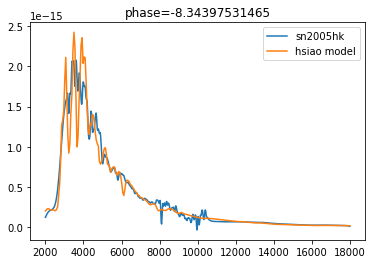

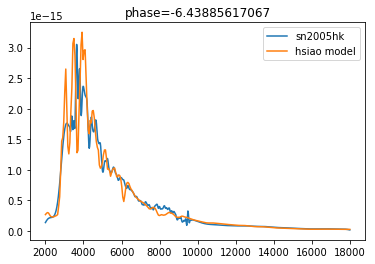

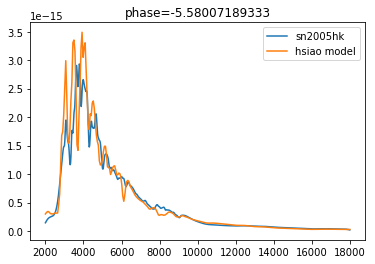

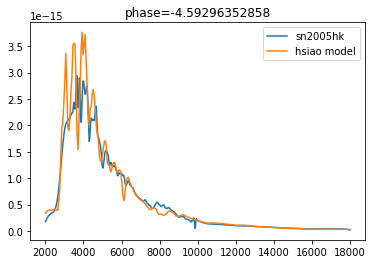

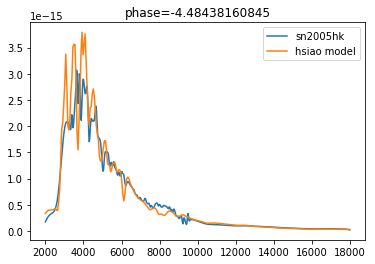

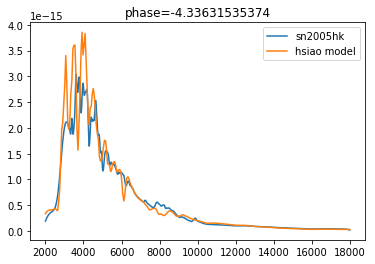

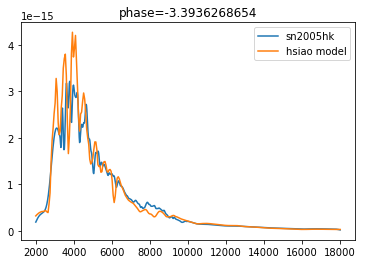

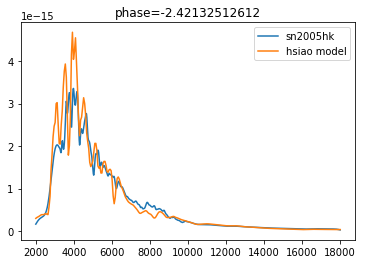

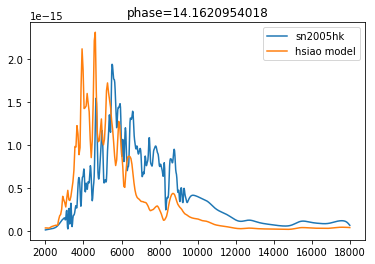

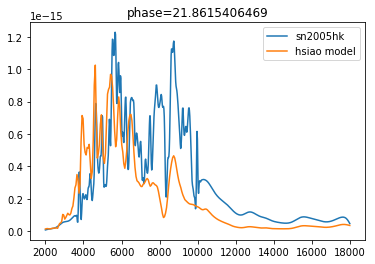

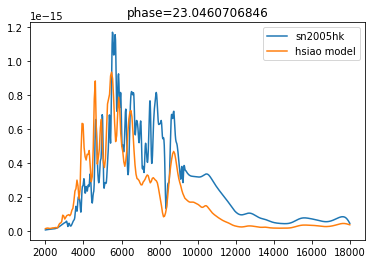

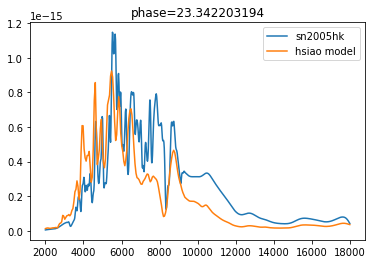

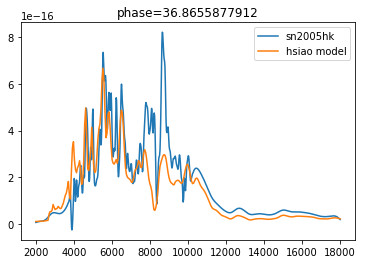

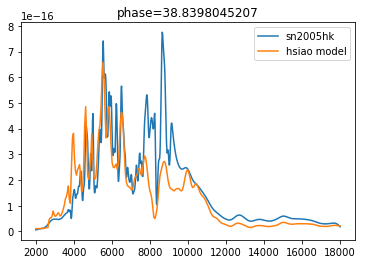

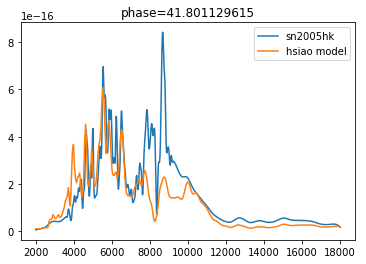

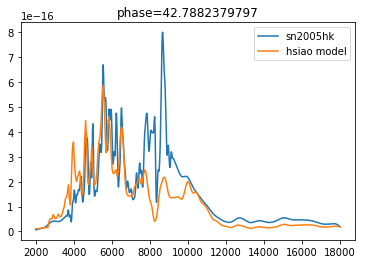

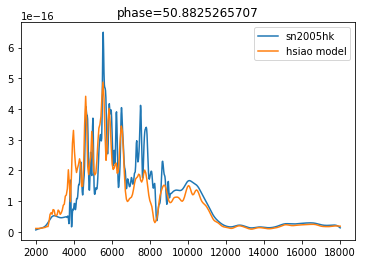

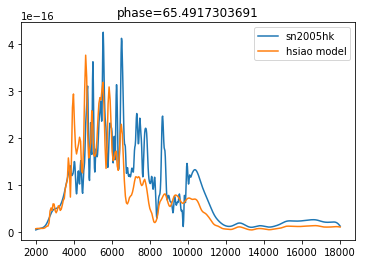

In [34]:
for i in range(0,len(sedres)):
    minwave = sedres[i].minwave
    maxwave = sedres[i].maxwave
    phase = sedres[i].phase
    wave = np.linspace(minwave,maxwave,800)
    flux = sedres[i].outsed.flux(phase,wave)
    hsed = sncosmo.Model(source='hsiao')
    hwave = np.linspace(hminw,hmaxw,300)
    hflux = hsed.flux(phase,hwave)
    synmag = sedres[i].outsed.bandmag('Bessellv','ab',phase)
    hsynmag = hsed.bandmag('Bessellv','ab',phase)
    scale = np.power(10.,-0.4*(synmag-hsynmag))
#     hvflux = hsed.flux(phase,5500)
#     scale = sedres[i].outsed.flux(phase,5500)/hvflux
#     print minwave,maxwave
    plt.plot(wave,flux,label='sn2005hk')
    plt.plot(hwave,hflux*scale,label='hsiao model')
    plt.title("phase="+str(phase))
    plt.legend()
    plt.show()

In [35]:
## write out after-mangling spectra
pickle_dict = {'sedres':sedres}
pickle_out = open("sn2005hk.pickle","wb")
pickle.dump(pickle_dict, pickle_out)
pickle_out.close()

In [36]:
## configure as sncosmo TimeSeriesSource (interpolated within sncosmo - 2dspline used?)
minw = hminw
maxw = hmaxw
wave = np.linspace(minw,maxw,300)
phase_arr = []
flux_arr = np.atleast_2d([[0.]*len(wave)]).T
inputsource = [-100,0,0]
for i in range(0,len(sedres)):
    minwave = sedres[i].minwave
    maxwave = sedres[i].maxwave
#     print minwave,maxwave
    if minwave>minw or maxwave<maxw:
        print "wavelength range is different from input"
        continue
    phase = sedres[i].phase
    if np.any(phase_arr == phase):
        continue
    phases = np.array(phase*len(wave)).ravel()
    flux = sedres[i].outsed.flux(phase,wave).ravel()
    inputsource = np.vstack([inputsource,zip(phases,wave,flux)])
    phase_arr.append(phase)
    flux = np.atleast_2d(flux).T
    flux_arr = np.hstack([flux_arr,flux])

source = sncosmo.TimeSeriesSource(phase_arr, wave, flux_arr[:,1:].T)    
print source

class      : TimeSeriesSource
name       : None
version    : None
phases     : [-8.34398, .., 65.4917] days
wavelengths: [2000, .., 18000] Angstroms
parameters:
  amplitude = 1.0


In [37]:
wave=np.linspace(3000,10000,300)
day = np.linspace(-8,65,30)
source.flux(day,wave)


array([[  1.76212483e-15,   1.73724963e-15,   1.58428673e-15, ...,
          1.35010958e-16,   7.33538311e-17,   1.10957806e-16],
       [  1.52066046e-15,   1.61737920e-15,   1.80084864e-15, ...,
          1.88469769e-16,   1.76026935e-16,   1.70905366e-16],
       [  2.02922307e-15,   2.07824652e-15,   2.11551578e-15, ...,
          1.97367931e-16,   2.08368851e-16,   2.09730088e-16],
       ..., 
       [  6.59137744e-17,   6.56076434e-17,   6.50648236e-17, ...,
          1.35885158e-16,   1.35614385e-16,   1.32543987e-16],
       [  6.17989531e-17,   6.16998453e-17,   6.14087111e-17, ...,
          1.37518706e-16,   1.33850991e-16,   1.25304816e-16],
       [  5.16777388e-17,   5.19274962e-17,   5.20866740e-17, ...,
          1.43517923e-16,   1.34640685e-16,   1.17910233e-16]])

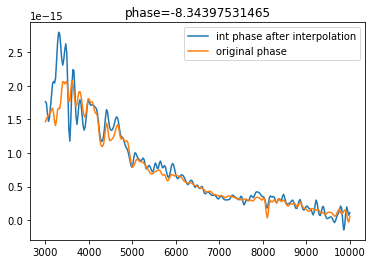

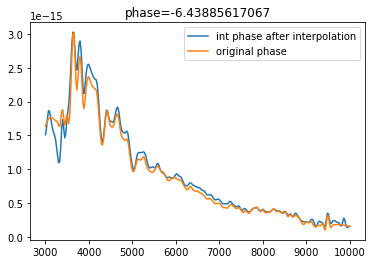

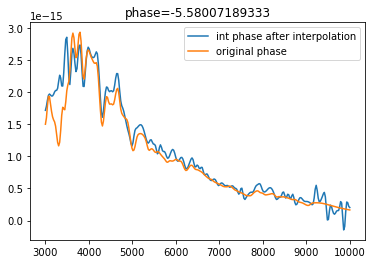

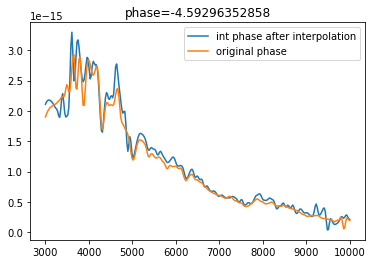

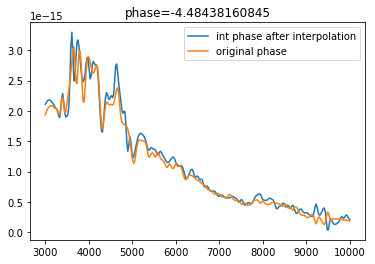

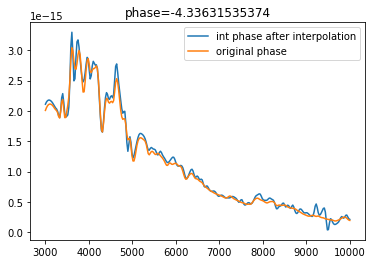

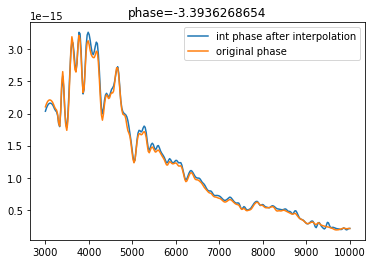

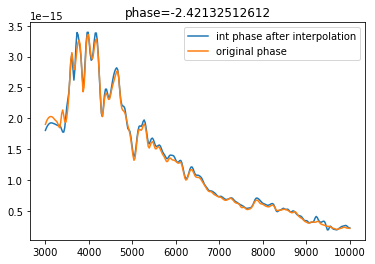

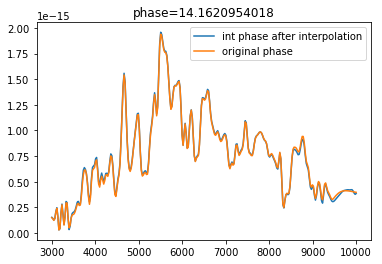

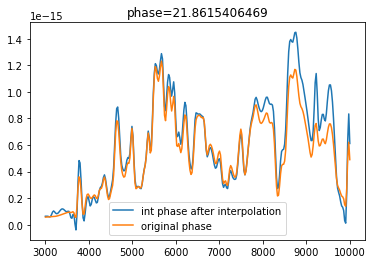

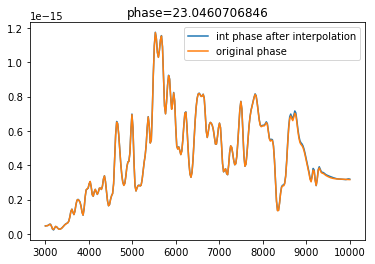

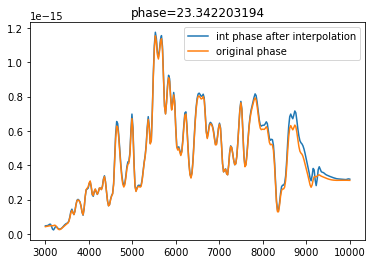

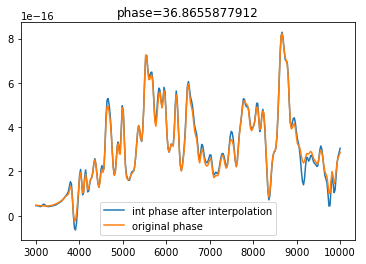

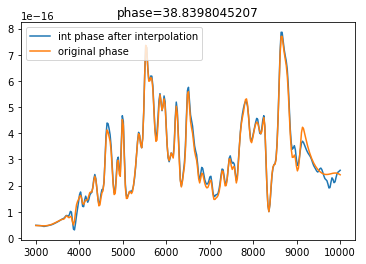

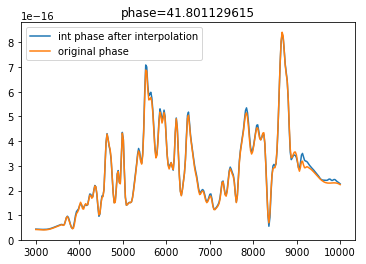

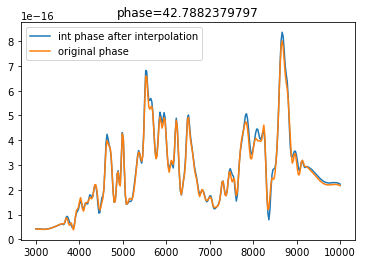

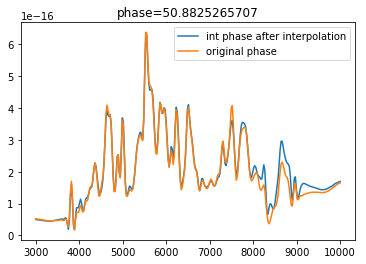

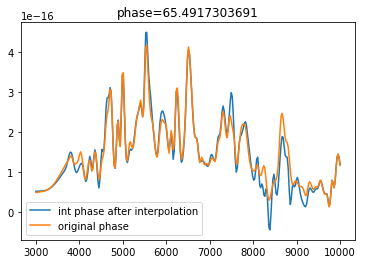

In [40]:
for i in range(0,len(sedres)):
    phase = sedres[i].phase
    plt.plot(wave,source.flux(int(phase),wave),label='int phase after interpolation')
    flux = sedres[i].outsed.flux(phase,wave)
    plt.plot(wave,flux,label='original phase')
    plt.legend()
    plt.title('phase={}'.format(phase))
    plt.show()

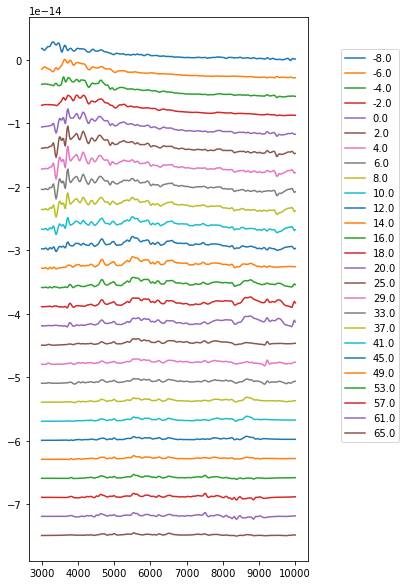

In [54]:
plt.figure(figsize=(5,10))
days = np.concatenate([[-8.,-6.],np.linspace(-4.,20.,13),np.linspace(25.,65.,11)])
for i,d in enumerate(days):
    plt.plot(wave,source.flux(d,wave)-i*3.e-15,label=str(d))
plt.legend(bbox_to_anchor=(1.1, 0.95))